# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [4]:
# %run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [7]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [8]:
results=(rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])*dataframe)
drift=results.copy()

for col in drift.columns:
    drift[col]=drift[col]/results.sum(axis=1)
performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)
last_weights=rolling_optimization.loc[dates_end[-3]]
weights_bench=pd.DataFrame(drift.iloc[-1])
weights_bench.columns=['Weights Model']

# Importing Data

In [10]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [11]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [13]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [14]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [15]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [16]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [17]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

BNBUSDT 0
USDTTRY 1
JASMYUSDT 2
BNBUSDT 3
BBUSDT 4
USDTTRY 5
BNBUSDT 6
USDTTRY 7
TRXUSDT 8
USDTTRY 9
JASMYUSDT 10
BNBUSDT 11
BBUSDT 12
OMUSDT 13
OMUSDT 14
OMUSDT 15
TRXUSDT 16
BTCUSDT 17
OMUSDT 18
BTCUSDT 19
TRXUSDT 20
TRXUSDT 21
BBUSDT 22
BNBUSDT 23
TRXUSDT 24
BTCUSDT 25
TRXUSDT 26
BTCUSDT 27
MKRUSDT 28
BTCUSDT 29
MKRUSDT 30
EURUSDT 31
EURUSDT 32
BBUSDT 33
BNBUSDT 34
JASMYUSDT 35
PEPEUSDT 36
NOTUSDT 37
NOTUSDT 38
NOTUSDT 39
BBUSDT 40
BBUSDT 41
PEPEUSDT 42
JASMYUSDT 43
BTCUSDT 44
BTCUSDT 45
TRXUSDT 46
BTCUSDT 47
BNBUSDT 48
BTCUSDT 49
BNBUSDT 50
BTCUSDT 51
BNBUSDT 52
BTCUSDT 53
BNBUSDT 54
BTCUSDT 55
BNBUSDT 56
BNBUSDT 57
BTCUSDT 58
BNBUSDT 59
JASMYUSDT 60
JASMYUSDT 61
ENSUSDT 62
ARUSDT 63
BTCUSDT 64
UMAUSDT 65
BTCUSDT 66
UMAUSDT 67
ETHUSDT 68
XRPUSDT 69
BTCUSDT 70
XRPUSDT 71
BTCUSDT 72
NEARUSDT 73
BTCUSDT 74
LPTUSDT 75
BTCUSDT 76
NEARUSDT 77
EURUSDT 78
BTCUSDT 79
INJUSDT 80
BTCUSDT 81
FETUSDT 82
EURUSDT 83
EURUSDT 84
EURUSDT 85
EURUSDT 86
EURUSDT 87
EURUSDT 88
EURUSDT 89
EURUSDT 90
EURU

In [18]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)


In [19]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_93156\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [20]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


USDUSDT not retrieved


In [21]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [22]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],weights_bench,realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2204.356711,2221.039234,0.9999,1.000000,-317.657477,334.34,16.682523,0.756798
BTCUSDT,68795.528445,608.894087,1001.771994,0.4510,0.447100,-12.309557,392.88,380.570443,17.264467
TRXUSDT,0.202233,216.871947,389.169732,0.1752,0.373291,-12.296183,172.30,160.003817,7.258527
SOLUSDT,157.055962,281.199764,367.828630,0.1656,0.000000,0.000000,86.63,86.630000,3.929945
ETHUSDT,3654.532716,253.391959,333.642356,0.1502,0.000000,0.000000,80.25,80.250000,3.640518
OMUSDT,1.129917,526.321302,110.815084,0.0499,0.000000,0.000000,-415.51,-415.510000,-18.849490
BNBUSDT,0.932084,0.018936,17.811435,0.0080,0.139687,-19.757911,17.79,-1.967911,-0.089274
BCHUSDT,0.000000,0.000000,0.000000,0.0000,0.039921,0.000000,0.00,0.000000,0.000000
XLMUSDT,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000
LINKUSDT,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000


In [23]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [24]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [25]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [26]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [27]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [28]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [30]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 44e91d117302b76bfdf72cad71c031a865c8691a)
✅ File pushed/updated successfully!


In [31]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [32]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [33]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [34]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 0ea6715cd4f054868dad58e1f0b0578f74bb9161)
✅ File pushed/updated successfully!


In [35]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [36]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [37]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [38]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [39]:
# pnl_history['Total']

In [40]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [41]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [42]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [43]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)#+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [44]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -223.722931
2024-09-25   -240.969439
2024-09-26   -155.270221
2024-09-27   -138.751101
                 ...    
2025-08-19    -64.169880
2025-08-20      3.585922
2025-08-21    -47.085793
2025-08-22    371.834735
2025-08-23    354.156000
Name: Total, Length: 335, dtype: float64

<Axes: >

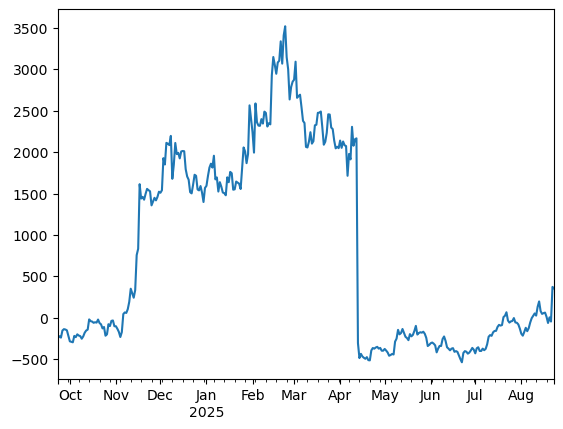

In [45]:
pnl_history['Total'].plot()

In [46]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-07-24    -25.169421
2025-07-25     14.611312
2025-07-26      4.924152
2025-07-27     35.123826
2025-07-28    -52.773000
2025-07-29     -3.735193
2025-07-30    -20.315121
2025-07-31    -49.767968
2025-08-01    -62.484839
2025-08-02    -23.659997
2025-08-03     44.829219
2025-08-04     50.440091
2025-08-05    -41.020054
2025-08-06     36.413389
2025-08-07     68.439267
2025-08-08     52.242167
2025-08-09     28.619211
2025-08-10     28.580156
2025-08-11    -26.126058
2025-08-12    106.411481
2025-08-13     65.040275
2025-08-14   -116.944819
2025-08-15    -33.788702
2025-08-16      9.416085
2025-08-17      6.186404
2025-08-18    -51.411836
2025-08-19    -74.026161
2025-08-20     67.755802
2025-08-21    -50.671715
2025-08-22    418.920529
2025-08-23    -17.678735
Name: Total, dtype: float64

In [47]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-370.76237949843164, -950.5160328166937)

In [48]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [49]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [50]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [51]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [52]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [53]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [54]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

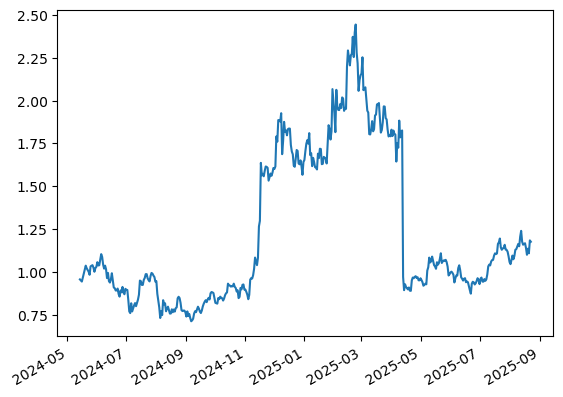

In [55]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

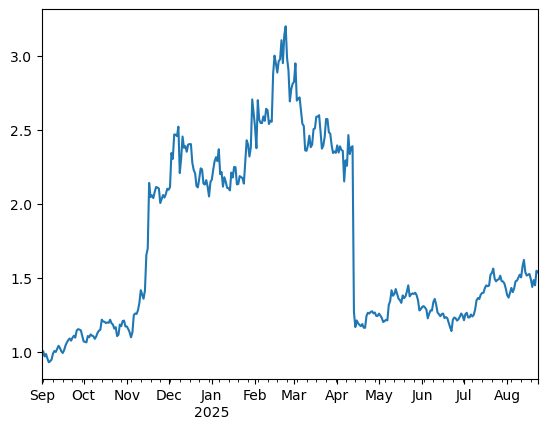

In [56]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [58]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [61]:
days=90
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [62]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
TRXUSDT,0.5675
WBETHUSDT,0.2969
ADAUSDT,0.0975
BCHUSDT,0.0381
BNBUSDT,0.0000
BTCUSDT,0.0000
WBTCUSDT,0.0000
LTCUSDT,0.0000
XRPUSDT,0.0000
XLMUSDT,0.0000


In [66]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
TRXUSDT,0.642957
WBETHUSDT,0.304485
BCHUSDT,0.052559


In [67]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

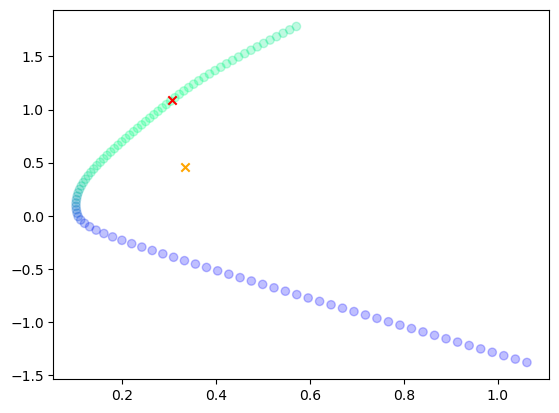

In [68]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [69]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [70]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1001.7720,0.4510,0.0000,0.4510
TRXUSDT,389.1697,0.1752,0.3167,-0.1415
SOLUSDT,367.8286,0.1656,0.0000,0.1656
ETHUSDT,333.6424,0.1502,0.0000,0.1502
OMUSDT,110.8151,0.0499,0.0000,0.0499
BNBUSDT,17.8114,0.0080,0.0000,0.0080
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.0139,-0.0139
WBETHUSDT,0.0000,0.0000,0.3004,-0.3004
BCHUSDT,0.0000,0.0000,0.0524,-0.0524


### Current results

In [72]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [73]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.670407
ETHUSDT,0.329593


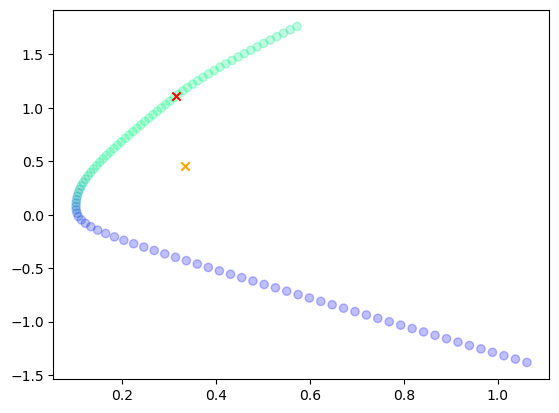

In [74]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [75]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1001.7720,0.4510,0.0000,0.4510
TRXUSDT,389.1697,0.1752,0.6704,-0.4952
SOLUSDT,367.8286,0.1656,0.0000,0.1656
ETHUSDT,333.6424,0.1502,0.3296,-0.1794
OMUSDT,110.8151,0.0499,0.0000,0.0499
BNBUSDT,17.8114,0.0080,0.0000,0.0080
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [77]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [78]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

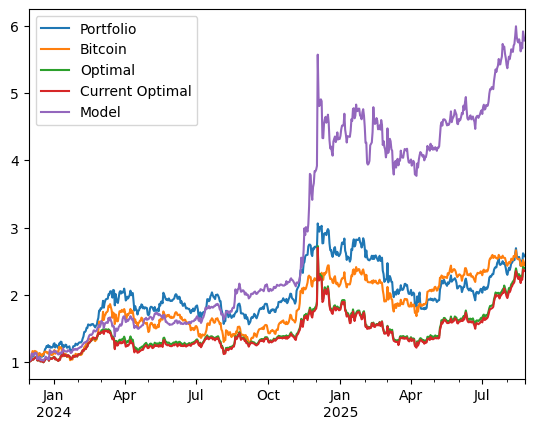

In [79]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [80]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

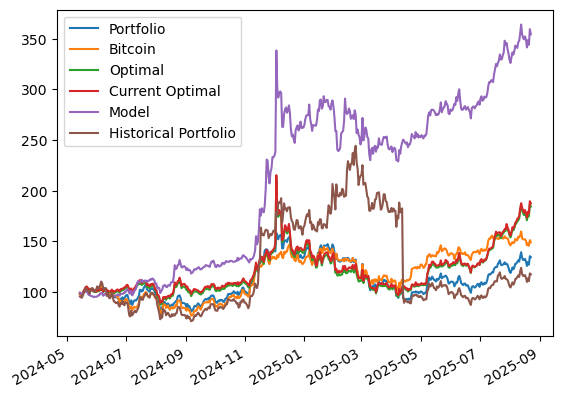

In [81]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

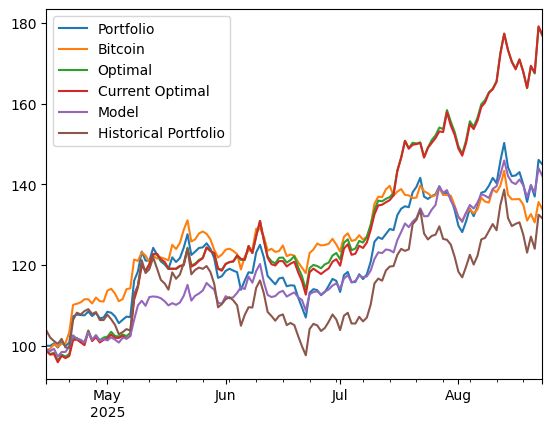

In [82]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

## Volatilities

In [84]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.309467
 dtype: float64,
 0.3094669773917631)

In [85]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.334982
 dtype: float64,
 0.33498182368654544)

In [86]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.428159
Bitcoin            0.406927
Optimal            0.470137
Current Optimal    0.474771
Model              0.469322
dtype: float64

In [87]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20454466319935455

In [88]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

1.0177611703650402

<Axes: >

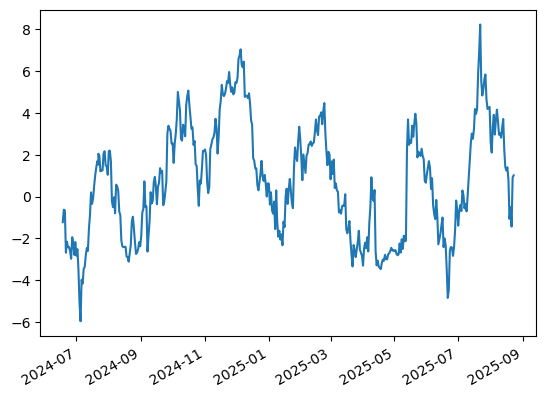

In [89]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [90]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.37043449245647

## Risk Contribution

In [92]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
WBETHUSDT,23.8350,0.4929,0.3159,0.1770
TRXUSDT,19.8296,0.4601,0.2974,0.1627
BCHUSDT,1.8755,0.0470,0.0076,0.0394
Portfolio,45.5401,1.0000,0.6209,0.3791


In [93]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
ETHUSDT,25.351150,0.523697,0.359613,0.164084
TRXUSDT,20.676168,0.476303,0.312219,0.164084
Portfolio,46.027318,1.000000,0.671832,0.328168


In [94]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
ETHUSDT,11.423247,0.233070,0.064540,0.168531
TRXUSDT,5.496455,0.085099,0.019503,0.065597
SOLUSDT,1.767676,0.272916,0.088876,0.184040
BTCUSDT,1.006693,0.299658,0.114181,0.185477
BNBUSDT,0.274613,0.007939,0.000087,0.007852
OMUSDT,-2.446338,0.101316,0.024643,0.076673
Portfolio,17.522345,1.000000,0.311830,0.688170


# Value At Risk

## Historical

### Optimal Weights

In [98]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.03285157925347962, -0.035812537719147254)

### Current Weights

In [100]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.03996717330602302, -0.0401997725921976)

In [101]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [102]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.006821
TRXUSDT     -0.005067
SOLUSDT     -0.010961
ETHUSDT     -0.005757
OMUSDT      -0.011040
BNBUSDT     -0.000293
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.039938
Name: 2025-05-30 00:00:00, dtype: float64

In [103]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.012654
TRXUSDT     -0.003673
SOLUSDT     -0.009343
ETHUSDT     -0.006113
OMUSDT      -0.008096
BNBUSDT     -0.000191
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.040069
dtype: float64

## Parametric

### Optimal Weights

In [106]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.04535119141964319, -0.056170417251809344)

### Current Weights

In [108]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.049090293691911174, -0.06080154001189435)

## Multivariate

### Optimal Weights

In [111]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.041412906344379226, -0.04791864357458522)

### Current Weights

In [113]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0484051230378423, -0.0564630400617728)

In [114]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.014680
TRXUSDT     -0.003267
SOLUSDT     -0.013046
ETHUSDT     -0.010373
OMUSDT      -0.005299
BNBUSDT     -0.000389
Portfolio   -0.047055
dtype: float64

In [115]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.013930
TRXUSDT     -0.003436
SOLUSDT     -0.013133
ETHUSDT     -0.010488
OMUSDT      -0.006097
BNBUSDT     -0.000399
Portfolio   -0.047482
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [119]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0403709346206774, -0.04644879334059235)

### Current Weights

In [121]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04856222076479412, -0.05600372009018287)

In [122]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [125]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04163710597377711, -0.0488578505468211)

### Current Weights

In [127]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.050674824505739666, -0.059328039220128304)

In [128]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [131]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0833155814044818, -0.10521746678412855)

### Current Weights

In [133]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06152376875356906, -0.07432760452783443)

In [134]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [137]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [138]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04537999457746852, -0.05177857020521103)

### Current Weights

In [140]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.049637359439992285, -0.057583023427735476)

In [141]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [142]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.016985,-0.014188,-0.010250,-0.014680,-0.015069
TRXUSDT,-0.001976,-0.003637,-0.002986,-0.003267,-0.003752
SOLUSDT,-0.009939,-0.013367,-0.009385,-0.013046,-0.013540
ETHUSDT,-0.006992,-0.010490,-0.008318,-0.010373,-0.011087
OMUSDT,-0.003434,-0.005295,-0.003846,-0.005299,-0.005475
BNBUSDT,0.000104,-0.000374,-0.000272,-0.000389,-0.000380
Portfolio,-0.039222,-0.047351,-0.035056,-0.047055,-0.049303


In [143]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.014861,-0.015243,-0.010730,-0.013930,-0.015561
TRXUSDT,-0.002575,-0.003567,-0.002480,-0.003436,-0.003275
SOLUSDT,-0.010338,-0.012927,-0.009439,-0.013133,-0.014018
ETHUSDT,-0.007827,-0.010848,-0.008590,-0.010488,-0.011322
OMUSDT,-0.004287,-0.004993,-0.003895,-0.006097,-0.005428
BNBUSDT,0.000107,-0.000377,-0.000292,-0.000399,-0.000383
Portfolio,-0.039781,-0.047954,-0.035425,-0.047482,-0.049986


## VaR Violation

In [145]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.044677,-0.040835,-0.038339,0.004103
2023-12-31,-0.044677,-0.040882,-0.039359,0.006938
2024-01-01,-0.044677,-0.040840,-0.039086,0.011308
2024-01-02,-0.044677,-0.040833,-0.038895,0.002160
2024-01-03,-0.044677,-0.043024,-0.043051,-0.033717
...,...,...,...,...
2025-08-20,-0.024136,-0.045539,-0.042943,0.032684
2025-08-21,-0.024136,-0.045939,-0.042207,-0.010147
2025-08-22,-0.023787,-0.051833,-0.045872,0.068232
2025-08-23,-0.023787,-0.052255,-0.045452,-0.011640


In [146]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.053077,-0.057614,-0.050916,-0.036337
2023-12-16,-0.053077,-0.057386,-0.050976,0.009842
2023-12-17,-0.053077,-0.057683,-0.054372,-0.020246
2023-12-18,-0.053077,-0.058761,-0.054291,0.021284
2023-12-19,-0.053077,-0.057741,-0.054995,-0.009015
...,...,...,...,...
2025-08-20,-0.038930,-0.055045,-0.050246,0.030790
2025-08-21,-0.038930,-0.056150,-0.055174,-0.020295
2025-08-22,-0.038930,-0.067061,-0.062449,0.066197
2025-08-23,-0.038930,-0.067436,-0.063212,-0.007647


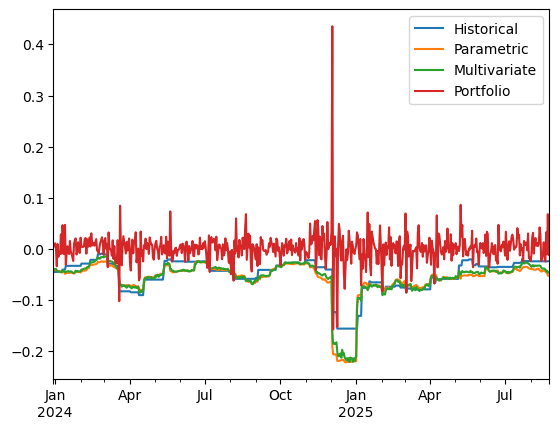

In [147]:
var_data.plot()
plt.show()

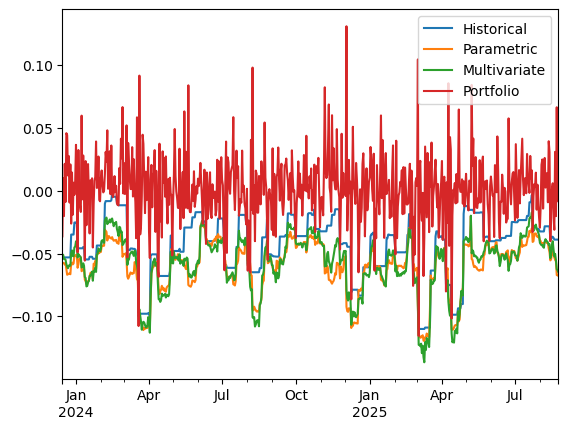

In [148]:
current_var_data.plot()
plt.show()


In [149]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.028146,0.014901,0.013245
Kupiec Stat,7.163986,21.382685,23.993632
P-value,0.007438,0.000004,0.000001


In [150]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069467,0.01454,0.012924
Kupiec Stat,4.427758,22.476643,25.137343
P-value,0.035359,0.000002,0.000001


# Principal Component Analysis

## Historical PCA

In [153]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78360937, 0.10018344, 0.05939288, 0.03145634, 0.02535796])

In [154]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.058009
AVAXUSDT     0.064114
BCHUSDT      0.031137
BNBUSDT      0.027977
BTCUSDT      0.021555
DOGEUSDT     0.071665
ETHUSDT      0.054627
HBARUSDT     0.070744
LINKUSDT     0.069446
LTCUSDT      0.046601
OMUSDT       0.082313
PAXGUSDT     0.000092
PEPEUSDT     0.078571
SOLUSDT      0.054798
SUIUSDT      0.072288
TRXUSDT      0.012810
USDCUSDT    -0.000045
WBETHUSDT    0.054367
WBTCUSDT     0.021483
XLMUSDT      0.057943
XRPUSDT      0.049505
Name: PC1, dtype: float64

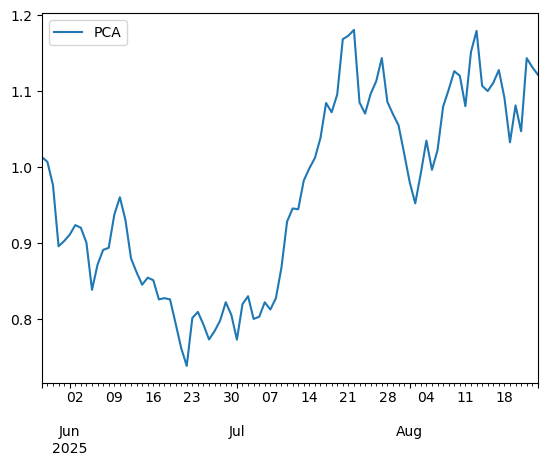

In [155]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

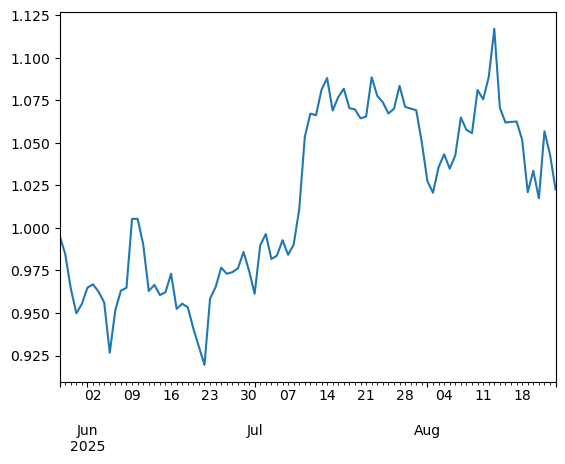

In [156]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [157]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
AVAXUSDT     0.145999
ADAUSDT      0.155685
ETHUSDT      0.160711
WBETHUSDT    0.161763
DOGEUSDT     0.171721
SOLUSDT      0.176678
LTCUSDT      0.187488
XRPUSDT      0.207692
BNBUSDT      0.209258
PEPEUSDT     0.211654
LINKUSDT     0.215171
SUIUSDT      0.226867
WBTCUSDT     0.235758
BTCUSDT      0.235953
HBARUSDT     0.258982
XLMUSDT      0.294642
BCHUSDT      0.300160
TRXUSDT      0.300373
USDCUSDT     0.338708
dtype: float64

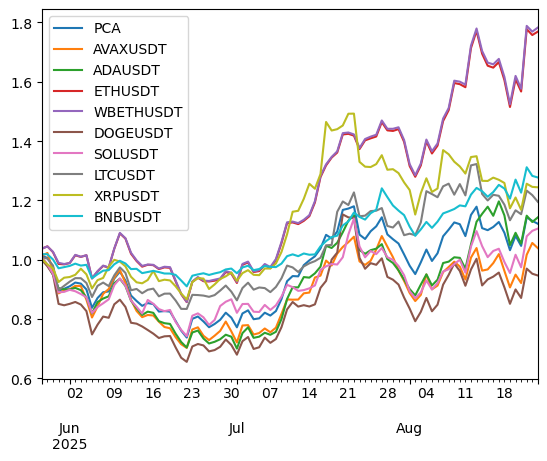

In [158]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

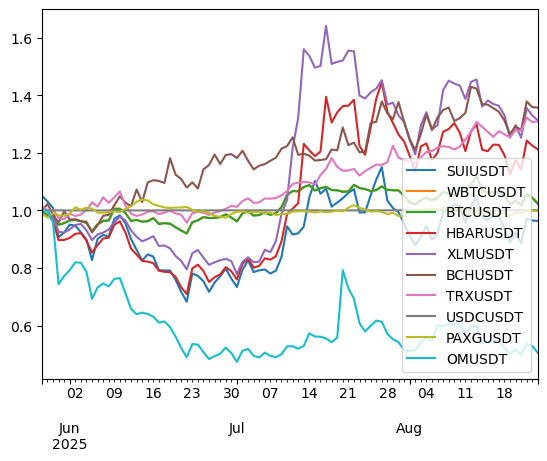

In [159]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [161]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75532475, 0.17156843, 0.03445001, 0.02109762, 0.01755918])

In [162]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT     0.056920
TRXUSDT     0.033726
SOLUSDT     0.152447
ETHUSDT     0.152657
OMUSDT      0.295810
BNBUSDT     0.077484
PEPEUSDT    0.230727
PAXGUSDT    0.000229
Name: PC1, dtype: float64

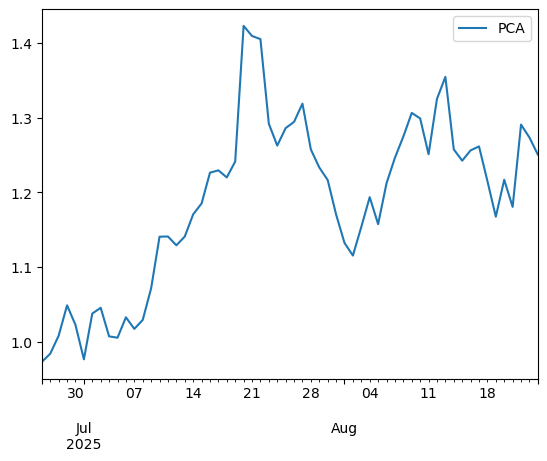

In [163]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

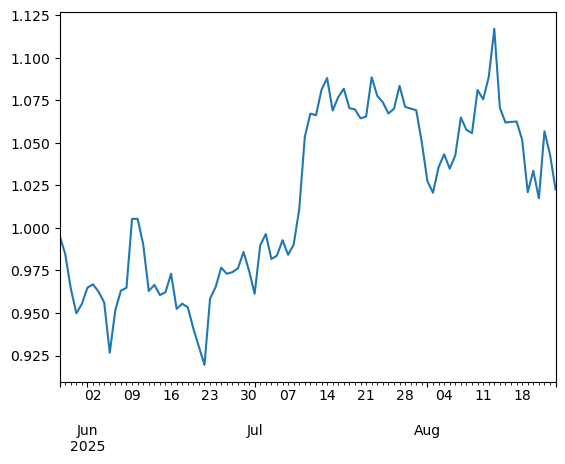

In [164]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [165]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
PEPEUSDT    0.201752
ETHUSDT     0.212733
SOLUSDT     0.222068
BNBUSDT     0.257783
BTCUSDT     0.286152
TRXUSDT     0.342358
OMUSDT      0.351223
PAXGUSDT    0.378783
dtype: float64

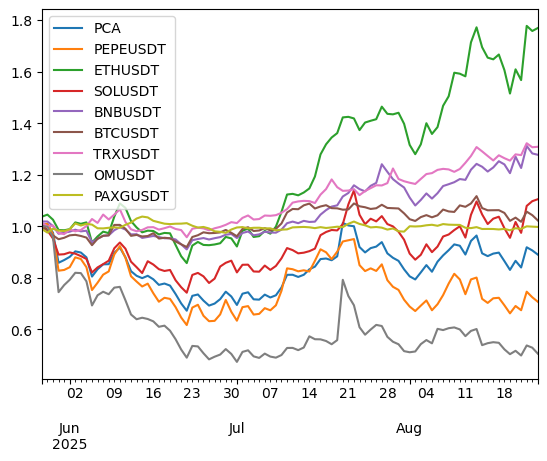

In [166]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [168]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.921826
SOLUSDT     1.291874
ETHUSDT     1.104982
OMUSDT      1.001317
BTCUSDT     1.000000
BNBUSDT     0.670210
TRXUSDT     0.334181
PAXGUSDT    0.030050
Name: BTCUSDT, dtype: float64

In [169]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    2.074768
ETHUSDT     2.037886
SOLUSDT     1.927159
OMUSDT      1.714774
BNBUSDT     1.215099
BTCUSDT     1.000000
TRXUSDT     0.546137
PAXGUSDT    0.107734
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [171]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [172]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PAXGUSDT,0.395790
ETHUSDT,0.270603
PEPEUSDT,0.219536
BNBUSDT,0.190260
BTCUSDT,0.162764
OMUSDT,0.125403
SOLUSDT,0.120909
TRXUSDT,-0.048229


### Regression to PCA

In [174]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.418718556692468

In [175]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA         1.000000
ETHUSDT     0.877579
BNBUSDT     0.767988
BTCUSDT     0.697286
SOLUSDT     0.564143
PEPEUSDT    0.310417
TRXUSDT     0.201739
OMUSDT      0.155745
PAXGUSDT    0.025555
dtype: float64

In [176]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PAXGUSDT    2.151200
BTCUSDT     1.865485
BNBUSDT     1.205498
TRXUSDT     1.056242
PCA         1.000000
SOLUSDT     0.852038
ETHUSDT     0.820123
PEPEUSDT    0.746184
OMUSDT      0.717447
dtype: float64

### Correlation Matrix

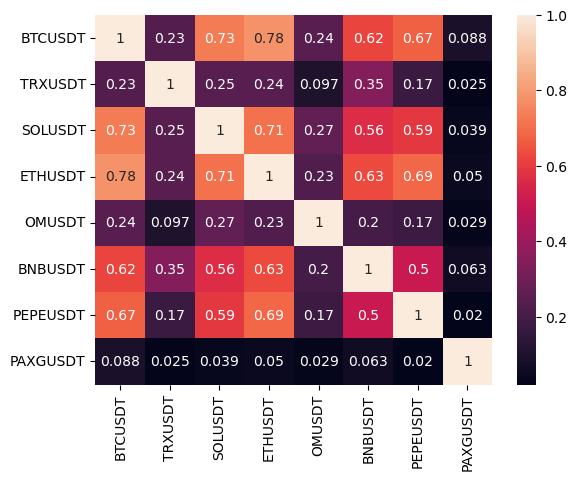

In [178]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

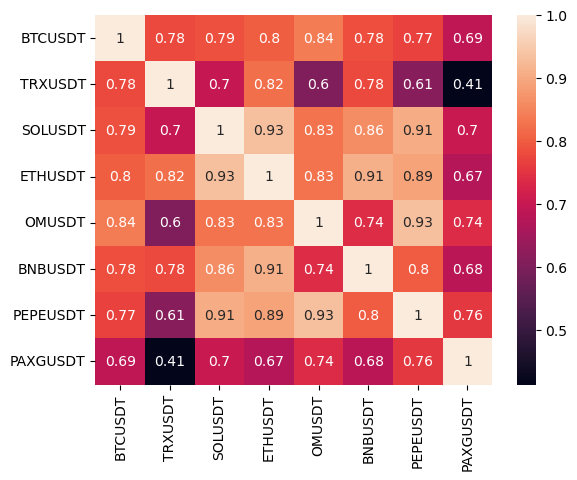

In [179]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [180]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [181]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

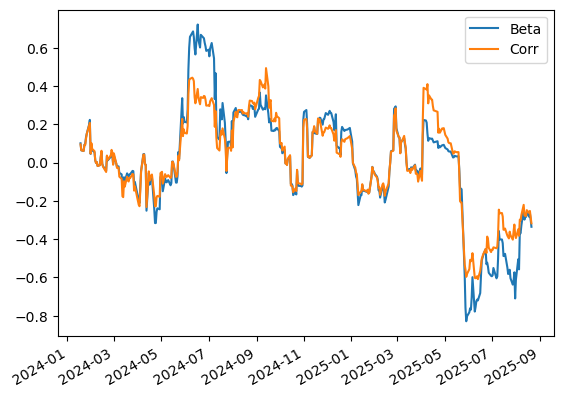

In [182]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [184]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,SOLUSDT,ETHUSDT,OMUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.107613,0.000000,0.000000,0.000000,0.104338,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.331762,0.000000,0.000000,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.000000,0.439739,0.560261,0.000000,0.000000,0.000000
2024-01-25,0.000000,0.379486,0.000000,0.000000,0.104620,0.000000,0.000000,0.515894
2024-02-08,0.000000,0.066364,0.041760,0.191143,0.047113,0.000000,0.000000,0.653620
2024-02-22,0.000000,0.705974,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.156080,0.020832,0.000000,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.000000,0.000000,0.462471,0.471815,0.065714,0.000000
2024-04-04,0.000920,0.000000,0.000000,0.000000,0.019296,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [185]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [186]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,ADAUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,LINKUSDT,LTCUSDT,...,PAXGUSDT,PEPEUSDT,SOLUSDT,SUIUSDT,TRXUSDT,USDCUSDT,WBETHUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2025-01-16,0.106751,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.291053,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.602197
2025-02-15,0.106751,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.254488,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
2025-03-17,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
2025-04-16,0.106750,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.651181,0.0,0.000004,0.000000,0.242065,0.0,0.000000,0.000000,0.00000,0.000000
2025-05-16,0.106751,0.0,0.000000,0.000000,0.038408,0.0,0.043594,0.000000,0.000000,0.252391,...,0.000000,0.0,0.000000,0.256069,0.257135,0.0,0.000000,0.045653,0.00000,0.000000
2025-06-15,0.106751,0.0,0.095107,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.798142,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
2025-07-15,0.106751,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.25767,0.635579
2025-08-14,0.106751,0.0,0.000000,0.123569,0.000000,0.0,0.007798,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.545437,0.0,0.216446,0.000000,0.00000,0.000000
2025-08-24,0.106751,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.893249,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000


In [187]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

TRXUSDT      0.545437
WBETHUSDT    0.216446
BNBUSDT      0.123569
ADAUSDT      0.106751
ETHUSDT      0.007798
PEPEUSDT     0.000000
Name: 2025-08-14 00:00:00, dtype: float64

In [190]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
